# IEMOCAP

In [3]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Load dataset
ds = load_dataset("AbstractTTS/IEMOCAP")

# Convert to pandas for easier manipulation
df = ds['train'].to_pandas()

# Extract features and labels
features = df[['speaking_rate', 'pitch_mean', 'pitch_std', 'rms', 'relative_db']].values
labels = df['major_emotion'].values

# Split into train/test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.3, 
    random_state=42,
    #stratify=labels
)

In [2]:
df.iloc[0].audio

{'bytes': b'RIFFV\xf3\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data2\xf3\x00\x00[\xff]\xff\x83\xff\x95\xff\xab\xff\xcb\xff\xd1\xff\xce\xff\xd9\xff\xf0\xff\x05\x00\x06\x00\x02\x00\x14\x00\x0f\x00\xeb\xff\xef\xff\x05\x00\x0c\x00\x17\x00\t\x00\xf4\xff\xe8\xff\xcb\xff\xad\xffs\xff:\xffV\xffw\xffX\xffJ\xffr\xff\xa3\xff\xb8\xff\xb9\xff\xe3\xff\r\x00\xf9\xff\xeb\xff\xe6\xff\xf3\xff8\x00L\x00/\x00L\x00d\x00R\x00a\x00k\x00G\x00%\x00\x1e\x00\x02\x00\xd4\xff\xd8\xff\xca\xff\xb9\xff\xe1\xff\xf4\xff\xed\xff\xe5\xff\xf2\xff\x13\x00\x10\x00\xe0\xff\xc6\xff\xbb\xff\x9b\xff\xb5\xff\xbc\xffj\xffL\xff\\\xffv\xff\xb1\xff\xe2\xff\x07\x00\x1b\x00\xf9\xff\xe4\xff\x00\x00\x14\x00\x13\x00\xe9\xff\xb5\xff\xbe\xff\xd1\xff\xe2\xff\x16\x00+\x009\x00t\x00\x81\x00b\x00W\x00W\x00W\x00F\x00$\x00\t\x00\xf1\xff\xce\xff\xb0\xff\xa8\xff\xad\xff\xbd\xff\xc0\xff\x9f\xff\x8f\xff\x80\xffI\xffR\xffu\xffa\xffG\xff?\xff\x85\xff\xac\xffz\xff\x98\xff\xb6\xff\xbd\xff\xd1\xff\xcd\xff\x

In [16]:
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# Preprocess audio
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base-960h",
    num_labels=len(np.unique(labels))
)

# Sample audio processing
def preprocess_audio(examples):
    audio_arrays = [x['array'] for x in examples['audio']]
    inputs = processor(
        audio_arrays, 
        sampling_rate=16000, 
        padding=True, 
        return_tensors="pt"
    )
    return inputs

# Apply to dataset
audio_ds = ds['train'].map(
    preprocess_audio,
    batched=True,
    batch_size=4
)
audio_ds = audio_ds.rename_column("major_emotion", "labels")

# Split dataset
split_ds = audio_ds.train_test_split(test_size=0.2)

# Create PyTorch DataLoader
from torch.utils.data import DataLoader
train_loader = DataLoader(split_ds['train'], batch_size=4, shuffle=True)
test_loader = DataLoader(split_ds['test'], batch_size=4)

2025-06-14 11:57:42.127173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 10039/10039 [14:59<00:00, 11.16 examples/s]


In [22]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import evaluate
import numpy as np

# 1. Load dataset
ds = load_dataset("AbstractTTS/IEMOCAP")
train_ds = ds['train']

# 2. Prepare label mapping
emotions = train_ds['major_emotion']
unique_emotions = sorted(set(emotions))
label2id = {label: i for i, label in enumerate(unique_emotions)}
id2label = {i: label for i, label in enumerate(unique_emotions)}
num_labels = len(unique_emotions)

print(f"Detected {num_labels} emotion classes: {unique_emotions}")

# 3. Initialize processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base-960h",
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label
)

# 4. FIXED: Audio preprocessing function (use dict access instead of attributes)
def preprocess_function(examples):
    audio_arrays = [x['array'] for x in examples['audio']]
    inputs = processor(
        audio_arrays, 
        sampling_rate=16000, 
        padding=True, 
        truncation=True,
        max_length=48000,  # 3 seconds at 16kHz
        return_tensors="pt"
    )
    
    # Convert emotion labels to IDs
    labels = []
    for emotion in examples['major_emotion']:
        if emotion in label2id:
            labels.append(label2id[emotion])
        else:
            # Handle any unexpected labels
            print(f"Warning: Unknown emotion '{emotion}', using default")
            labels.append(0)  # Default to first class
    
    return {
        'input_values': inputs['input_values'],        # FIX: Use dict access
        'attention_mask': inputs['attention_mask'],    # FIX: Use dict access
        'labels': torch.tensor(labels)
    }

# 5. Apply preprocessing with smaller batches
batch_size = 4
encoded_ds = train_ds.map(
    preprocess_function,
    batched=True,
    batch_size=batch_size,
    remove_columns=train_ds.column_names
)

# 6. Split dataset (80/20)
split_ds = encoded_ds.train_test_split(test_size=0.2)

# 7. Set up training arguments
training_args = TrainingArguments(
    output_dir="./emotion_classifier_results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
)

# 8. Metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }

# 9. Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_ds["train"],
    eval_dataset=split_ds["test"],
    compute_metrics=compute_metrics,
)

# 10. Train and evaluate
print("Starting training...")
trainer.train()

print("\nEvaluation results:")
results = trainer.evaluate()
print(results)

# Save model
trainer.save_model("./emotion_classifier_final")
print("Model saved successfully!")

Detected 10 emotion classes: ['angry', 'disgust', 'excited', 'fear', 'frustrated', 'happy', 'neutral', 'other', 'sad', 'surprise']


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/10039 [00:00<?, ? examples/s]


KeyError: 'attention_mask'

# Train with audio

In [ ]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, load_metric
import numpy as np

# 1. Load dataset with streaming to avoid memory issues
ds = load_dataset("AbstractTTS/IEMOCAP", streaming=True)
train_ds = ds['train']

# 2. Prepare label mappings
label_names = train_ds.features['major_emotion'].names
label2id = {label: i for i, label in enumerate(label_names)}
id2label = {i: label for i, label in enumerate(label_names)}

# 3. Initialize processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base-960h",
    num_labels=len(label_names),
    label2id=label2id,
    id2label=id2label
)

# 4. Audio preprocessing function
def preprocess_function(examples):
    audio_arrays = [x['array'] for x in examples['audio']]
    inputs = processor(
        audio_arrays, 
        sampling_rate=16000, 
        padding=True, 
        truncation=True,
        max_length=100000,  # ~6 seconds at 16kHz
        return_tensors="pt"
    )
    labels = [label2id[emotion] for emotion in examples['major_emotion']]
    return {
        'input_values': inputs.input_values,
        'attention_mask': inputs.attention_mask,
        'labels': labels
    }

# 5. Apply preprocessing in batches
batch_size = 4
encoded_ds = train_ds.map(
    preprocess_function,
    batched=True,
    batch_size=batch_size,
    remove_columns=train_ds.column_names
)

# 6. Split dataset (80/20)
split_ds = encoded_ds.train_test_split(test_size=0.2)

# 7. Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# 8. Metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    accuracy = load_metric("accuracy").compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_metric("f1").compute(predictions=predictions, references=labels, average="weighted")["f1"]
    return {"accuracy": accuracy, "f1": f1}

# 9. Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_ds["train"],
    eval_dataset=split_ds["test"],
    compute_metrics=compute_metrics,
)

# 10. Train and evaluate
trainer.train()
results = trainer.evaluate()
print(results)

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Performance SVM with feature scaling
               precision    recall  f1-score   support

       angry       0.62      0.20      0.31       382
     disgust       0.00      0.00      0.00         1
     excited       0.55      0.01      0.02       579
        fear       0.00      0.00      0.00        31
  frustrated       0.33      0.86      0.48       912
       happy       0.00      0.00      0.00       202
     neutral       0.00      0.00      0.00       523
       other       0.00      0.00      0.00         9
         sad       0.33      0.48      0.39       346
    surprise       0.00      0.00      0.00        27

    accuracy                           0.34      3012
   macro avg       0.18      0.16      0.12      3012
weighted avg       0.32      0.34      0.23      3012



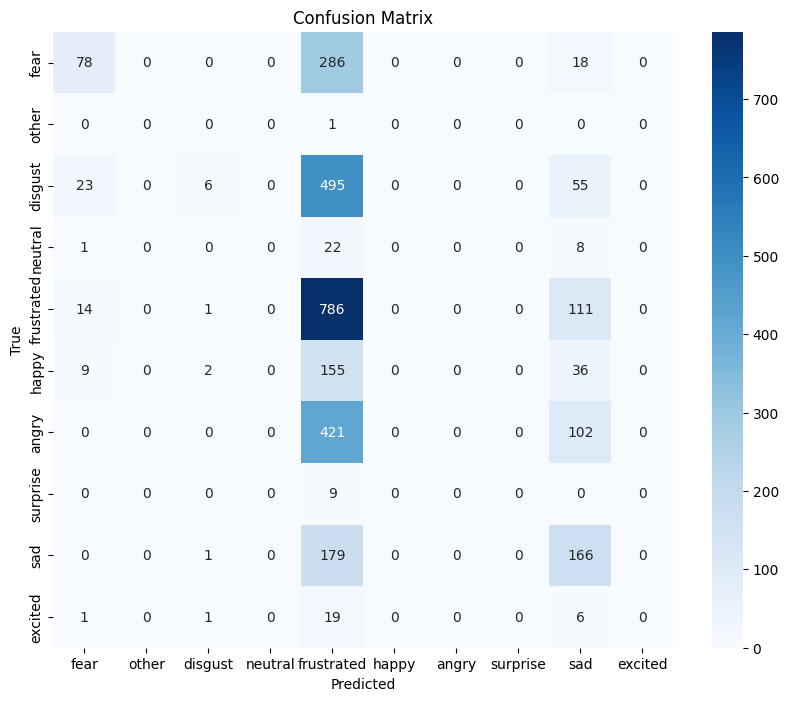

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


## Simple SVM(1) classifier with feature scaling (2)
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train the model
clf12 = svm.SVC(kernel='linear')
clf12.fit(X_train_scaled, y_train)
pred12 = clf12.predict(X_test_scaled)
print("Performance SVM with feature scaling\n", classification_report(y_test, pred12))

# Generate a confusion matrix
cm = confusion_matrix(y_test, pred12)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(label_names), yticklabels=set(label_names))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:

from datasets import load_dataset
import numpy as np

# 1. Load dataset
ds = load_dataset("AbstractTTS/IEMOCAP", streaming=True)
train_ds = ds['train']

# 2. Define target classes
target_classes = ["happiness", "anger", "sadness", "neutral"]

# 3. Filter dataset
def filter_classes(example):
    return example['major_emotion'].lower() in target_classes

filtered_ds = train_ds.filter(filter_classes)

# 4. Prepare label mapping
label2id = {cls: idx for idx, cls in enumerate(target_classes)}
id2label = {idx: cls for idx, cls in enumerate(target_classes)}

import opensmile
from tqdm import tqdm

# Initialize OpenSMILE
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01b, #eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

# Extract features
X = []
y = []

for example in tqdm(filtered_ds, desc="Extracting features"):
    try:
        audio_data = example['audio']
        features = smile.process_signal(
            audio_data['array'], 
            audio_data['sampling_rate']
        ).values.flatten()
        
        X.append(features)
        y.append(label2id[example['major_emotion'].lower()])
    except Exception as e:
        print(f"Skipping file due to error: {e}")

X = np.array(X)
y = np.array(y)

print(f"Final dataset size: {len(X)} samples")
print(f"Class distribution: {np.bincount(y)}")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Train SVM
clf = SVC(kernel='linear', random_state=42, probability=True)
clf.fit(X_train_scaled, y_train)

# 4. Evaluate
y_pred = clf.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_classes))

print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_classes, 
            yticklabels=target_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Emotion Recognition')
plt.show()

Extracting features: 0it [00:00, ?it/s]'(ReadTimeoutError("HTTPSConnectionPool(host='cdn-lfs-us-1.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 98429dea-6cf8-4303-b90b-13198d83ae99)')' thrown while requesting GET https://huggingface.co/datasets/AbstractTTS/IEMOCAP/resolve/9f1696a135a65ce997d898d4121c952269a822ca/data/train-00000-of-00003.parquet
Retrying in 1s [Retry 1/5].
Extracting features: 19it [00:14,  7.26it/s]'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: a9bc1a06-1513-41ff-a90c-e1e364434530)')' thrown while requesting GET https://huggingface.co/datasets/AbstractTTS/IEMOCAP/resolve/9f1696a135a65ce997d898d4121c952269a822ca/data/train-00000-of-00003.parquet
Retrying in 1s [Retry 1/5].
Extracting features: 19it [00:32,  7.26it/s]'(ReadTimeoutError("HTTPSConnectionPool(host='cdn-lfs-us-1.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ba22c314-b7ed-4864-89ba-3d

Final dataset size: 1726 samples
Class distribution: [   0    0    0 1726]


ValueError: The number of classes has to be greater than one; got 1 class

In [ ]:
# Class distribution visualization
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.xticks(ticks=range(len(target_classes)), labels=target_classes)
plt.title('Class Distribution in Filtered Dataset')
plt.show()

# Feature importance analysis
coef = clf.coef_
plt.figure(figsize=(12, 6))
sns.barplot(x=np.arange(len(coef[0])[:50], y=np.mean(np.abs(coef), axis=0)[:50]))
plt.title('Top 50 Most Important Features (Average Absolute Coefficient)')
plt.xlabel('Feature Index')
plt.ylabel('Average |Coefficient|')
plt.show()

# OpenSMILE

In [ ]:
import opensmile
import numpy as np
from tqdm import tqdm

# Initialize OpenSMILE with GeMAPS feature set
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.Functionals,
)

def extract_opensmile_features(audio_dict):
    """
    Extract OpenSMILE features from audio dictionary
    Returns flattened feature vector of 6373 dimensions
    """
    audio_array = audio_dict['array']
    sampling_rate = audio_dict['sampling_rate']
    
    # Process audio signal
    features = smile.process_signal(audio_array, sampling_rate)
    
    # Return as flattened numpy array
    return features.values.flatten()

# Extract features from the dataset
X = []
y = []

# Process with progress bar
for example in tqdm(df, total=10039, desc="Extracting OpenSMILE features"):
    try:
        features = extract_opensmile_features(example['audio'])
        X.append(features)
        y.append(example['major_emotion'])
    except Exception as e:
        print(f"Error processing example: {e}")
        continue

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Save features to disk for later use
np.savez('iemocap_GeMAPSv01a_features.npz', X=X, y=y)

# Load features from disk
data = np.load('iemocap_GeMAPSv01a_features.npz')
X = data['X']
y = data['y']



Extracting OpenSMILE features:   0%|          | 22/10039 [00:00<00:00, 44171.70it/s]

Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processing example: string indices must be integers
Error processi

Classification Report:
              precision    recall  f1-score   support

       angry       0.54      0.26      0.35       260
     disgust       0.00      0.00      0.00         1
     excited       0.39      0.27      0.32       394
        fear       0.00      0.00      0.00        24
  frustrated       0.38      0.67      0.49       602
       happy       0.00      0.00      0.00       130
     neutral       0.31      0.24      0.27       344
       other       0.00      0.00      0.00         7
         sad       0.44      0.54      0.49       227
    surprise       0.00      0.00      0.00        19

    accuracy                           0.39      2008
   macro avg       0.21      0.20      0.19      2008
weighted avg       0.36      0.39      0.35      2008



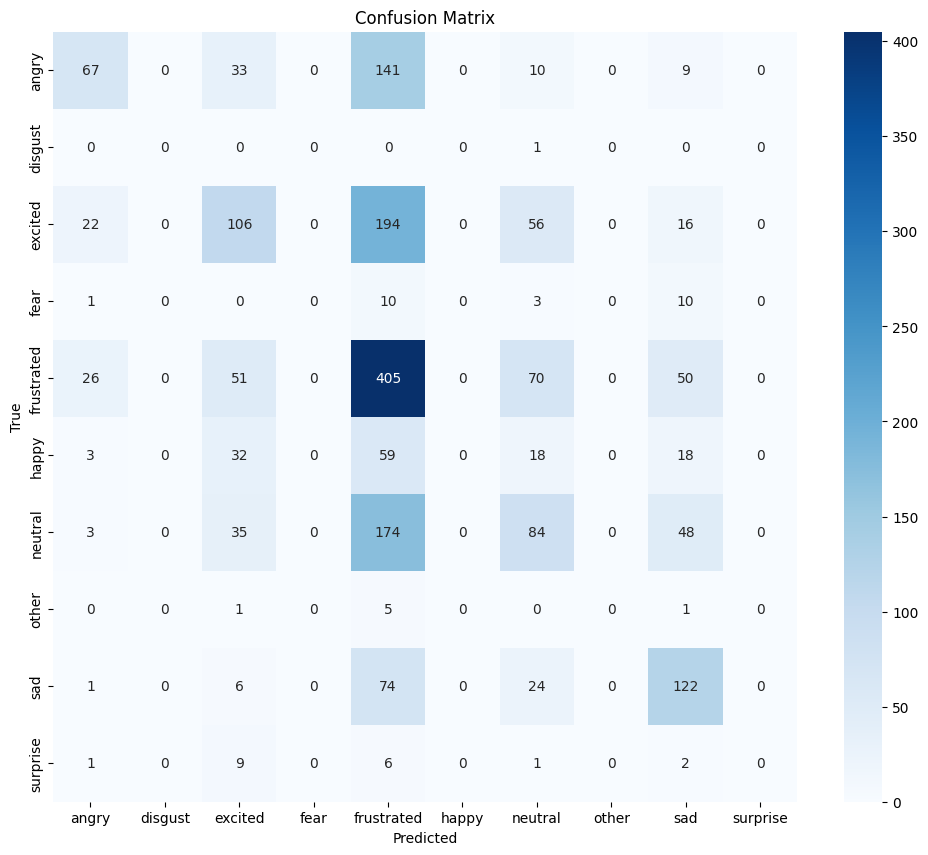

Overall Accuracy: 0.3904382470119522.


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Encode string labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split dataset (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM classifier
clf = svm.SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = clf.predict(X_test_scaled)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}.")

eGeMAPSv02: Overall Accuracy: 0.399402390438247.

GeMAPSv01b Overall Accuracy: 0.39243027888446214.

GeMAPSv01a 

In [29]:
len(train_ds)

10039

Extracted 10039 samples with 62 features each.
Class distribution: {'angry': 1269, 'disgust': 2, 'excited': 1976, 'fear': 107, 'frustrated': 2917, 'happy': 656, 'neutral': 1726, 'other': 26, 'sad': 1250, 'surprise': 110}


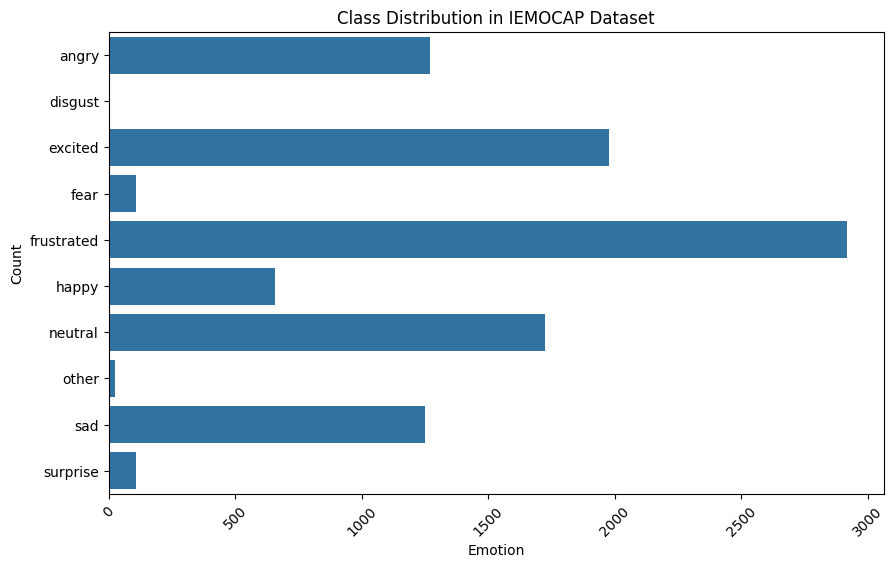

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the saved features
data = np.load('iemocap_GeMAPSv01a_features.npz')
X = data['X']
y = data['y']
print(f"Extracted {X.shape[0]} samples with {X.shape[1]} features each.")
# Check class distribution
unique, counts = np.unique(y, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution:", class_distribution)

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=y, order=sorted(class_distribution.keys()))
plt.title('Class Distribution in IEMOCAP Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define the parameter grid
param_grid = {
    'C': [0.1, 10, 100], #[0.1, 1, 10, 100],
    'gamma': [1, 0.01, 0.001], #[1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'sigmoid'], #['rbf', 'linear', 'poly', 'sigmoid']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2)
# Run grid search
grid_search.fit(X_train_scaled, y_train)


Training set shape: (8031, 62), Testing set shape: (2008, 62)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.6s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   5.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   5.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   5.2s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   5.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   5.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   7.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   7.7s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 10, 100], 'gamma': [1, 0.01, 0.001],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=2)

In [3]:
# Results analysis
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)
print("Test accuracy:", grid_search.score(X_test, y_test))

# Save results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv('IEMOCAP_SVM_grid_search_results.csv', index=False)
results_df

Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best CV accuracy: 0.42609799437547907
Test accuracy: 0.010956175298804782


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.920219,0.062231,2.761120,0.082398,0.1,1,rbf,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.289981,0.290785,0.290785,0.290785,0.290162,0.290499,0.000354,15
1,4.049374,0.111299,1.028686,0.015869,0.1,1,sigmoid,"{'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}",0.222775,0.214819,0.211083,0.192403,0.213574,0.210931,0.010057,18
2,4.874690,0.047928,2.661358,0.031486,0.1,0.01,rbf,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.364655,0.367372,0.370486,0.361768,0.368618,0.366580,0.003062,6
3,4.688513,0.017144,0.911133,0.026337,0.1,0.01,sigmoid,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.343497,0.352428,0.362391,0.349315,0.352428,0.352012,0.006129,8
4,4.881359,0.075843,2.730783,0.034857,0.1,0.001,rbf,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.319228,0.314446,0.316936,0.318804,0.320672,0.318018,0.002148,9
5,4.511853,0.082191,0.817819,0.012277,0.1,0.001,sigmoid,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}",0.298693,0.295766,0.301993,0.295143,0.300125,0.298344,0.002588,10
6,10.580501,0.028276,2.740706,0.007916,10,1,rbf,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.290604,0.291407,0.291407,0.290785,0.291407,0.291122,0.000354,13
7,3.837914,0.092235,1.007593,0.015172,10,1,sigmoid,"{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}",0.224642,0.212329,0.218555,0.193649,0.223537,0.214542,0.011318,16
8,5.494097,0.025489,2.595841,0.025219,10,0.01,rbf,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.425016,0.404732,0.437111,0.409714,0.420922,0.419499,0.011458,2
9,2.889713,0.054097,0.755288,0.011062,10,0.01,sigmoid,"{'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.294337,0.324408,0.316936,0.273350,0.281445,0.298095,0.019754,11


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pandas as pd
from src.select_features import FeatureSelector


# Create pipeline with fixed SVM params and feature selector
pipeline = Pipeline([
    ('selector', FeatureSelector()),
    ('clf', SVC(C=10, gamma='scale', kernel='rbf', random_state=42))  # Fixed SVM params
])

# Define parameter grid for feature selection
param_grid = {
    'selector__algorithm': ['algorithm1', 'algorithm2'],
    'selector__L': [0.7, 0.8, 0.9, 0.95],
    'selector__MS': [0.7, 0.75, 0.8],  # Only used with algorithm2
    'selector__dispersion_measure': ['MM', 'MAD', 'TV', 'AMGM']
}

# Configure grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Run grid search
grid_search.fit(X_train, y_train)

# Results analysis
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)
print("Test accuracy:", grid_search.score(X_test, y_test))

# Save results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv('feature_selection_grid_search_results.csv', index=False)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=  28.7s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=  28.9s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=  28.8s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=  28.5s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=  28.9s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=  29.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MM; total time=  28.6s
[CV] END selector__L=0.7, selector__MS=0

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  25.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  25.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  25.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  25.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.3s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  26.3s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  26.4s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.4s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  26.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  25.7s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  25.5s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  15.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  15.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  16.4s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  17.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  17.1s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  18.0s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  18.5s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  19.6s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  15.3s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  16.5s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  17.3s
[CV] END selector__L=0.7, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=  25.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  24.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  24.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  24.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  23.5s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  22.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  22.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  22.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  22.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  24.8s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  29.2s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  30.7s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  30.1s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  30.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  26.8s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  26.6s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm1, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=  22.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time= 4.3min


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time= 4.2min


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time= 4.2min
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time= 4.3min


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time= 4.2min


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.3s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  15.3s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  14.3s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  13.5s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  13.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  13.9s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  15.0s
[CV] END selector__L=0.7, selector__MS=0.75, selector__algorithm=algorithm2, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=  26.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  24.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  23.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  21.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  20.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  18.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  19.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  20.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  21.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  21.9s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  22.6s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  22.7s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  23.9s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  23.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  25.9s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  26.7s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=  16.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  14.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  18.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  18.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.9s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.8s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  18.7s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  20.2s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  19.0s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  18.2s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  20.1s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  19.2s
[CV] END selector__L=0.7, selector__MS=0.8, selector__algorithm=algorithm2, selector__disper

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=  23.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  33.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  34.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  35.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  36.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  36.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  36.3s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  36.1s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  36.5s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  40.1s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  41.2s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  40.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  40.4s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=  19.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  18.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.8s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.7s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.4s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  19.9s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  18.2s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  21.4s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  18.4s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  18.3s
[CV] END selector__L=0.8, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=  28.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  23.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  23.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  23.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  23.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  24.6s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  26.8s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  27.0s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  27.5s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  27.5s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  27.3s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm1, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.1s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  18.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  17.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.6s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  21.1s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  21.2s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  23.6s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  23.3s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  18.7s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  19.6s
[CV] END selector__L=0.8, selector__MS=0.75, selector__algorithm=algorithm2, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=  35.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  31.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  31.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  29.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  28.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  28.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  28.2s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  27.9s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  27.4s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  28.6s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  26.0s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  26.2s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  24.5s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=  25.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  22.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  24.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  26.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  22.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  22.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.4s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  18.8s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.6s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  19.6s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  17.9s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  19.6s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  20.5s
[CV] END selector__L=0.8, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  30.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=  30.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  29.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  30.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  29.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  28.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  28.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  28.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  29.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  28.6s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  30.9s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  31.9s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  39.9s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  40.0s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  39.3s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  36.6s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=  27.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  27.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  27.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  26.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  25.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  26.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  28.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  24.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.6s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.6s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  17.7s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  21.0s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  17.8s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  17.0s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  16.6s
[CV] END selector__L=0.9, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=  32.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  31.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  31.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  31.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  30.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  29.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  29.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  30.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  31.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  31.7s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  32.4s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  31.6s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  30.6s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  30.8s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  30.5s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  30.9s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm1, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=  19.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  22.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  24.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  26.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  27.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  25.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  25.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  25.5s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  23.4s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  26.4s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  26.5s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  24.2s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  25.8s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  29.9s
[CV] END selector__L=0.9, selector__MS=0.75, selector__algorithm=algorithm2, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=  35.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  35.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  35.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  35.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  36.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  36.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  36.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  38.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  38.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  38.6s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  38.9s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  37.9s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  35.8s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  35.7s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  36.0s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  33.4s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=  18.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  19.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  22.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  24.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  24.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  21.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  18.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.5s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  17.4s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  19.0s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  17.6s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  19.1s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  21.3s
[CV] END selector__L=0.9, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersi

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=  31.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  30.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  29.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  29.4s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  28.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  28.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  28.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  28.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.2s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  24.8s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  31.4s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  31.9s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  33.1s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  33.7s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  33.8s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm1, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=  18.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  15.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  17.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  16.5s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  16.3s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  17.4s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  17.4s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  17.4s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  16.2s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  20.2s
[CV] END selector__L=0.95, selector__MS=0.7, selector__algorithm=algorithm2, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=  34.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  33.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  32.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  29.6s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  29.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  32.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  32.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  31.8s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  30.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  30.4s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  30.5s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  30.1s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  28.8s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  28.4s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  28.0s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  26.9s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm1, se

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=  19.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  28.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  28.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  25.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  23.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  25.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  25.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  26.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  25.2s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  25.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  23.8s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  26.4s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  25.5s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  24.0s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  22.4s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  22.7s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  25.3s
[CV] END selector__L=0.95, selector__MS=0.75, selector__algorithm=algorithm2, 

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=MAD; total time=  27.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  27.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.7s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  26.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  29.3s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=TV; total time=  30.7s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  31.2s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  39.9s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  40.0s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  38.6s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__dispersion_measure=AMGM; total time=  36.1s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm1, selector__

/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=MAD; total time=  26.6s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  25.3s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  27.9s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  31.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  29.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  27.0s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  27.1s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  29.5s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  22.2s


/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean
/Users/sofiafernandes/Documents/Repos/EmoReA/emorea-backend/src/select_features.py:54: RuntimeWarning: overflow encountered in scalar divide
  dispersions[i] = arithmetic_mean / geometric_mean


[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  18.8s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=TV; total time=  20.4s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  17.8s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  19.5s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  20.7s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  20.6s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__dispersion_measure=AMGM; total time=  21.6s
[CV] END selector__L=0.95, selector__MS=0.8, selector__algorithm=algorithm2, selector__

In [ ]:
import sys
import os
module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)
from sklearn.base import BaseEstimator, TransformerMixin
from src.select_features import algorithm1, algorithm2
import matplotlib.pyplot as plt
import numpy as np

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, algorithm='algorithm2', L=0.95, MS=0.8, dispersion_measure='MM'):
        self.algorithm = algorithm
        self.L = L
        self.MS = MS
        self.dispersion_measure = dispersion_measure
        self.selected_indices = None
        
    def fit(self, X, y=None):
        if self.algorithm == 'algorithm1':
            self.selected_indices = algorithm1(X, self.L, self.dispersion_measure)
        else:
            self.selected_indices = algorithm2(X, self.L, self.MS, self.dispersion_measure)
        return self
    
    def transform(self, X):
        return X[:, self.selected_indices]
    
# Visualizar máscara como imagem 2D
def plot_feature_mask(mask, title):
    # Calcular dimensões para visualização
    n_features = mask.shape[0]
    grid_size = int(np.ceil(np.sqrt(n_features)))
    pad = grid_size**2 - n_features
    
    # Aplicar padding e remodelar
    mask_padded = np.pad(mask, (0, pad))
    plt.imshow(mask_padded.reshape(grid_size, grid_size), cmap='gray')
    plt.title(title)
    plt.show()


ModuleNotFoundError: No module named 'select_features'

In [ ]:
import sys
import os
module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)

from src.select_features import FeatureSelector

